# Rod Pump Failure Analysis: Data Cleaning

## Data Cleaning To-Do:
* Update imputation functions with a column which describes whether imputation was used on that row
* Consider other types of imputation for quantitative variables (regression, etc)
* Update column descriptions

## Column Descriptions:
liquid volume = rod and pump amount of liquid pulling out of the hole so more stress added to the rod ---> MAIN factor 

stroke length -- how the pump is operating -- before a rod fails it behaves radically *hint*

YesterdaysAverageSPM = yesterday strokes per minute, how pump is operating 

max inclination -- inclination of the well (sometimes the well is not straight) --> a non-straight well might have an impact on rop pump failure due to more friction (but small impact)

H2S is corrosive to pump and harmful to humans

Primary/Secondary Set point = controls how pump is being operated 

bha_configuration = bottom hole assembly configuration - how they have assembled it (Question: does the internal configuration of how you put the sucker rod affect the failure type or lifetime?)

chemical groups - chemical treatments applied during the life of the rod

max_unguided_dls - dog leg severity - how sharply trajectory is. change in degrees per hundred feet. how severe the dog leg is.

AVG_OIL_VOLUME/water/liquid = avg production of oil water and liquid

route - location of well 

sideload data - ask Sarah

DESANDDEGAS_TYP - desand is the company name type. desand takes out the sand after fracking. sand may cause erosion. this is the desander type

rod api grade - how much stress (tensile and compression) it can take 

rod_has_guides and rod_sideload are related -- they can decide to use guides or not 

pump_bore - standard specification --> set up as categorical variables (other column)

Read in data from CSV and parse date columns.

In [1]:
import pandas as pd
raw_data = pd.read_csv('../rodpump_raw.csv', parse_dates=['lifetime_start','lifetime_end'])

Create `Lifetime` column which represents total lifetime in days.  
Drop `lifetime_end` and `lifetime_start` which are no longer necessary.

In [2]:
raw_data['lifetimedays'] = (raw_data['lifetime_end'] - raw_data['lifetime_start']).dt.days
del raw_data['FAILSTART']
del raw_data['lifetime_end']
del raw_data['lifetime_start']

Delete `NODEID`, `IDWELL`, and `REPORTTO` because they are redundant fields.

In [3]:
del raw_data['NODEID']
del raw_data['IDWELL']
del raw_data['REPORTTO']

Delete `tbguid` and `IDRECJOBPULL` because they are procedural identifiers.

In [4]:
del raw_data['tbguid']
del raw_data['IDRECJOBPULL']

Filter data to only include rods which have failed by removing rows where `FAILURETYPE` is null.

In [5]:
raw_data = raw_data[raw_data['FAILURETYPE'].notnull()]

Use seaborn heatmap to identify columns with null values.

<AxesSubplot:>

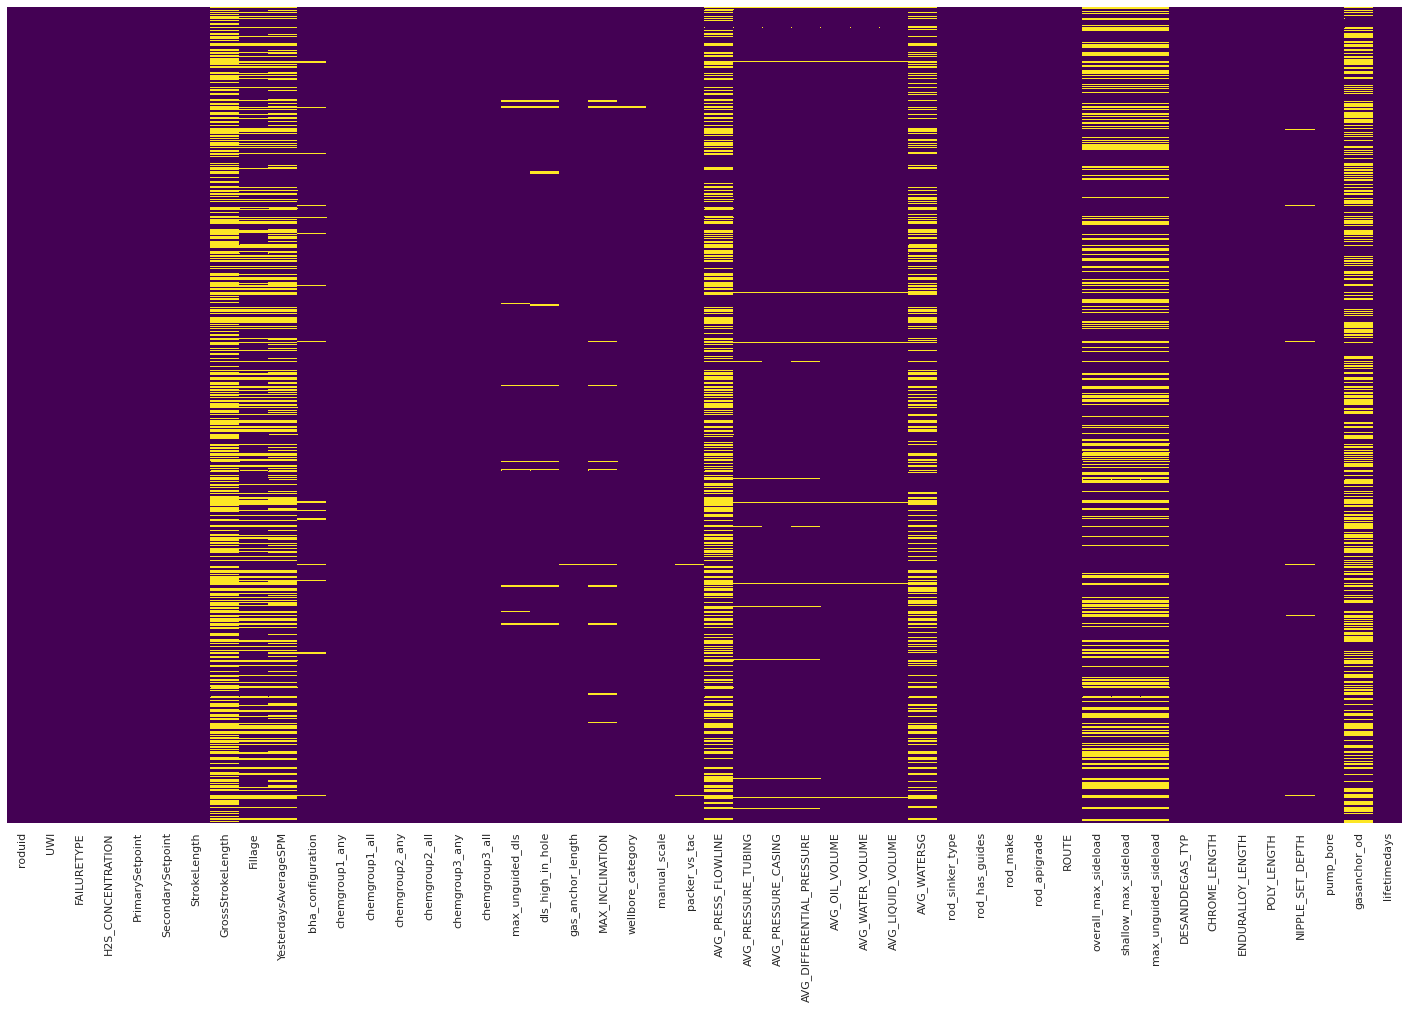

In [6]:
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(25,15)})
sns.heatmap(raw_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Consider `AVERAGE_WATERSG` column:  
Approximately 1/3rd of values are null;  
not-null values appear to be clustered around 1.05 and 1.19

<AxesSubplot:>

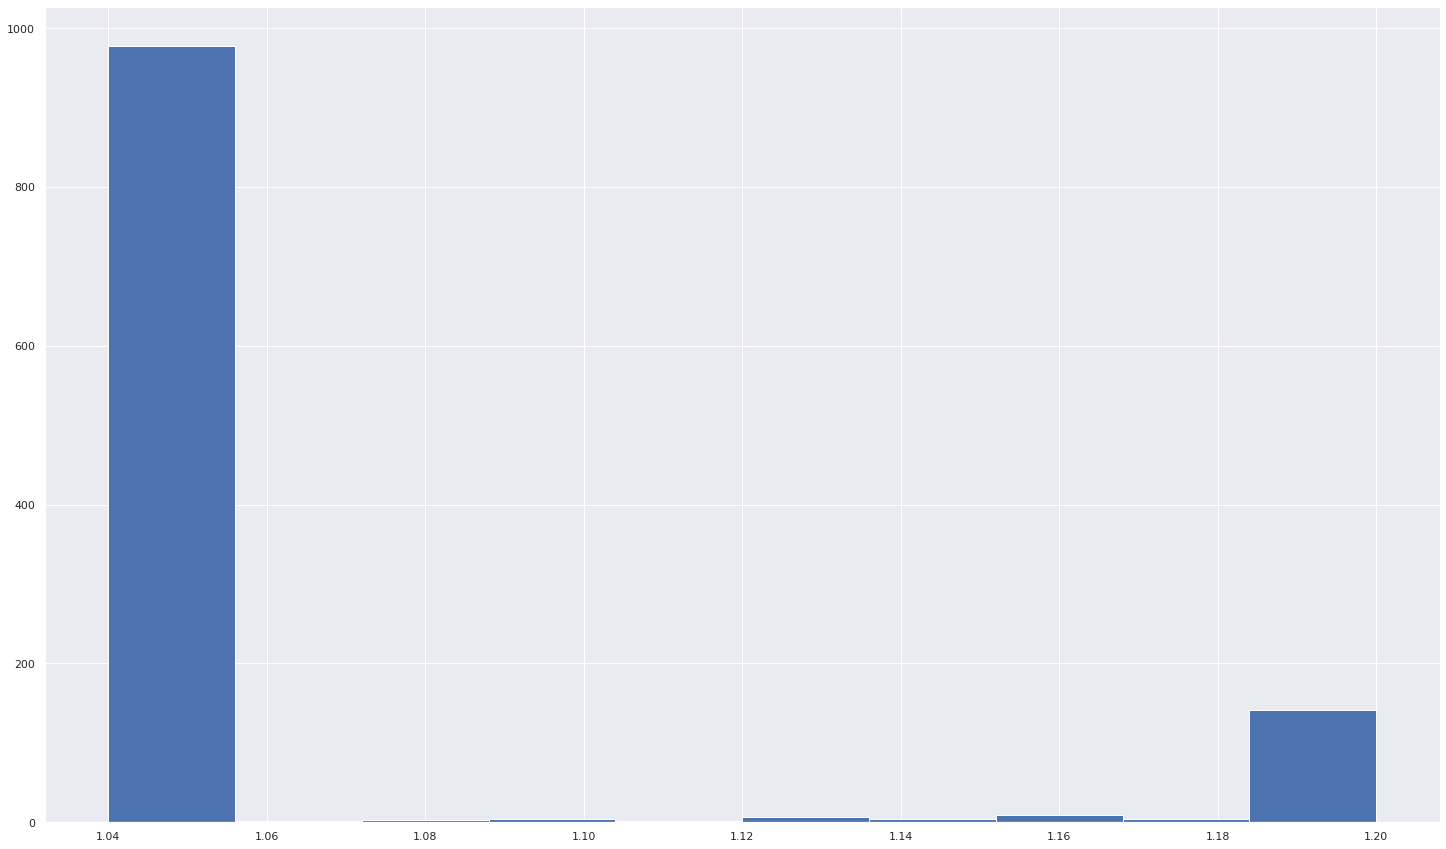

In [7]:
raw_data['AVG_WATERSG'].hist()

Check for improvements in the heatmap by removing rows with nulls in `AVG_WATERSG`.

<AxesSubplot:>

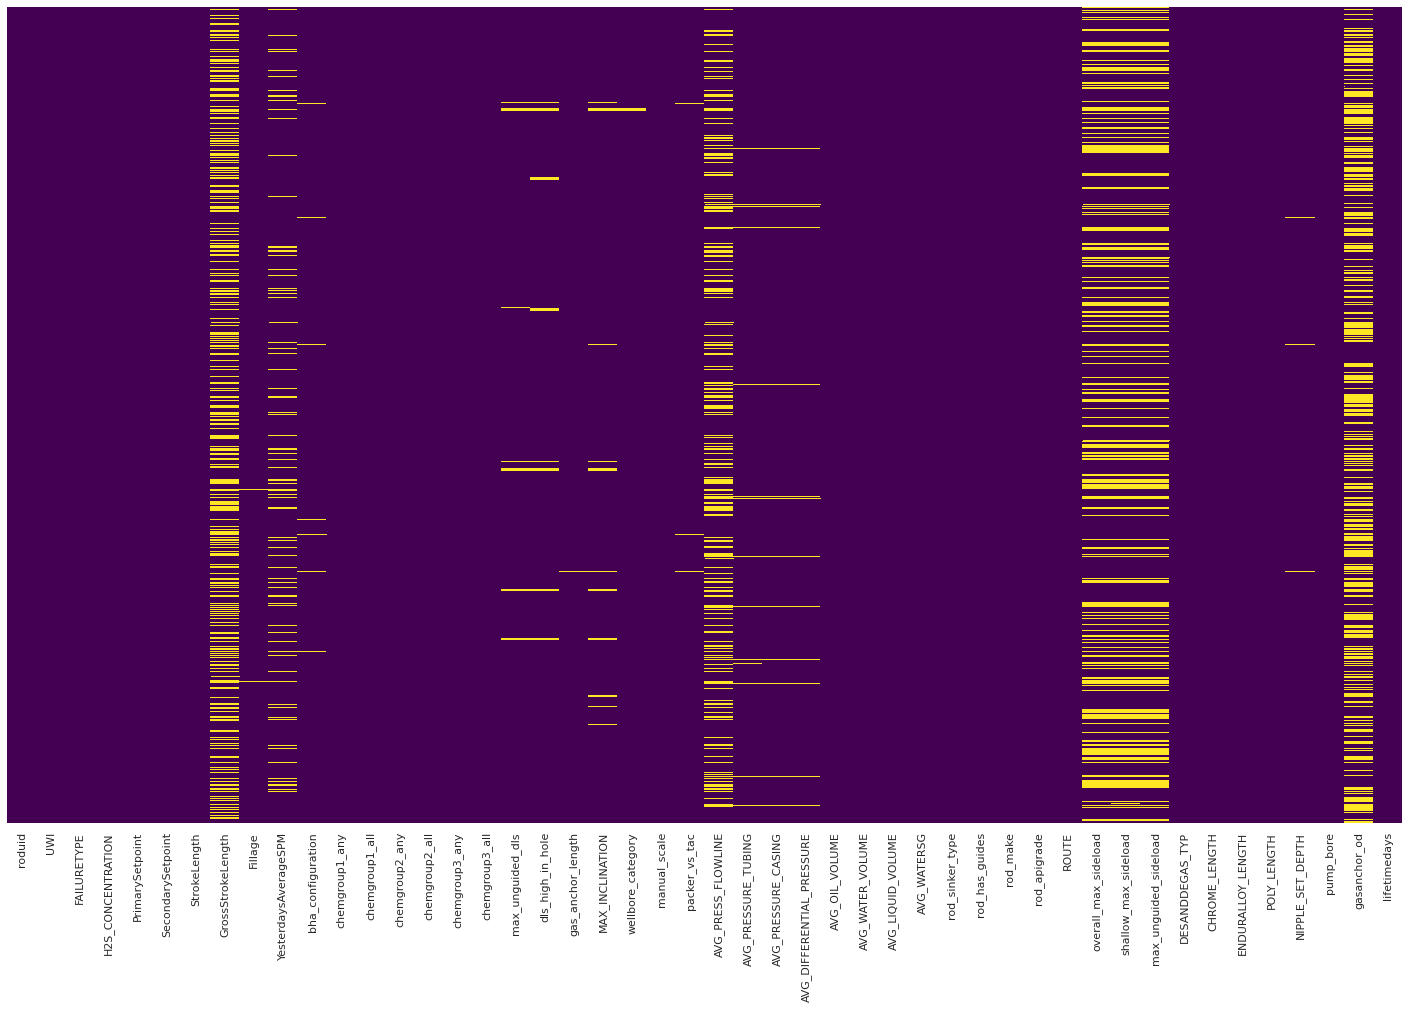

In [8]:
test_data = raw_data[raw_data['AVG_WATERSG'].notnull()]
sns.heatmap(test_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Removing null rows also significantly improved the integrity of `YesterdaysAverageSPM` and `Fillage`, but there are still issues with other columns.  
We will move forward using this dataset.

In [9]:
raw_data = test_data

Since we know that sideload data will be significant in our analysis, we opt *not to impute* sideload values, so we will drop rows with null sideload data.

In [10]:
raw_data = raw_data[raw_data['overall_max_sideload'].notnull()]

`gasanchor_od` has the next greatest percent null values, so we will consider this column next.

In [11]:
def getPercentNull(df, columnName):
    return df[columnName].isnull().sum() / (df[columnName].notnull().sum() + df[columnName].isnull().sum())
getPercentNull(raw_data,'gasanchor_od')

0.42555685814771393

In [12]:
raw_data['gasanchor_od'].value_counts()

OtherOrUnknown    334
4.5                87
2.875              59
3.5                10
Name: gasanchor_od, dtype: int64

A large majority of members within `gasanchor_od` are either null or OtherOrUnknown, so we will drop this column from the dataset as NEI.

In [13]:
del raw_data['gasanchor_od']

Next, we will consider the column `GrossStrokeLength`:

In [14]:
getPercentNull(raw_data,'GrossStrokeLength')

0.3622508792497069

Over 35% of data in this column is null, so we consider it for drop.

In [15]:
test_data = raw_data
del test_data['GrossStrokeLength']

Re-run heatmap to observe progress.

<AxesSubplot:>

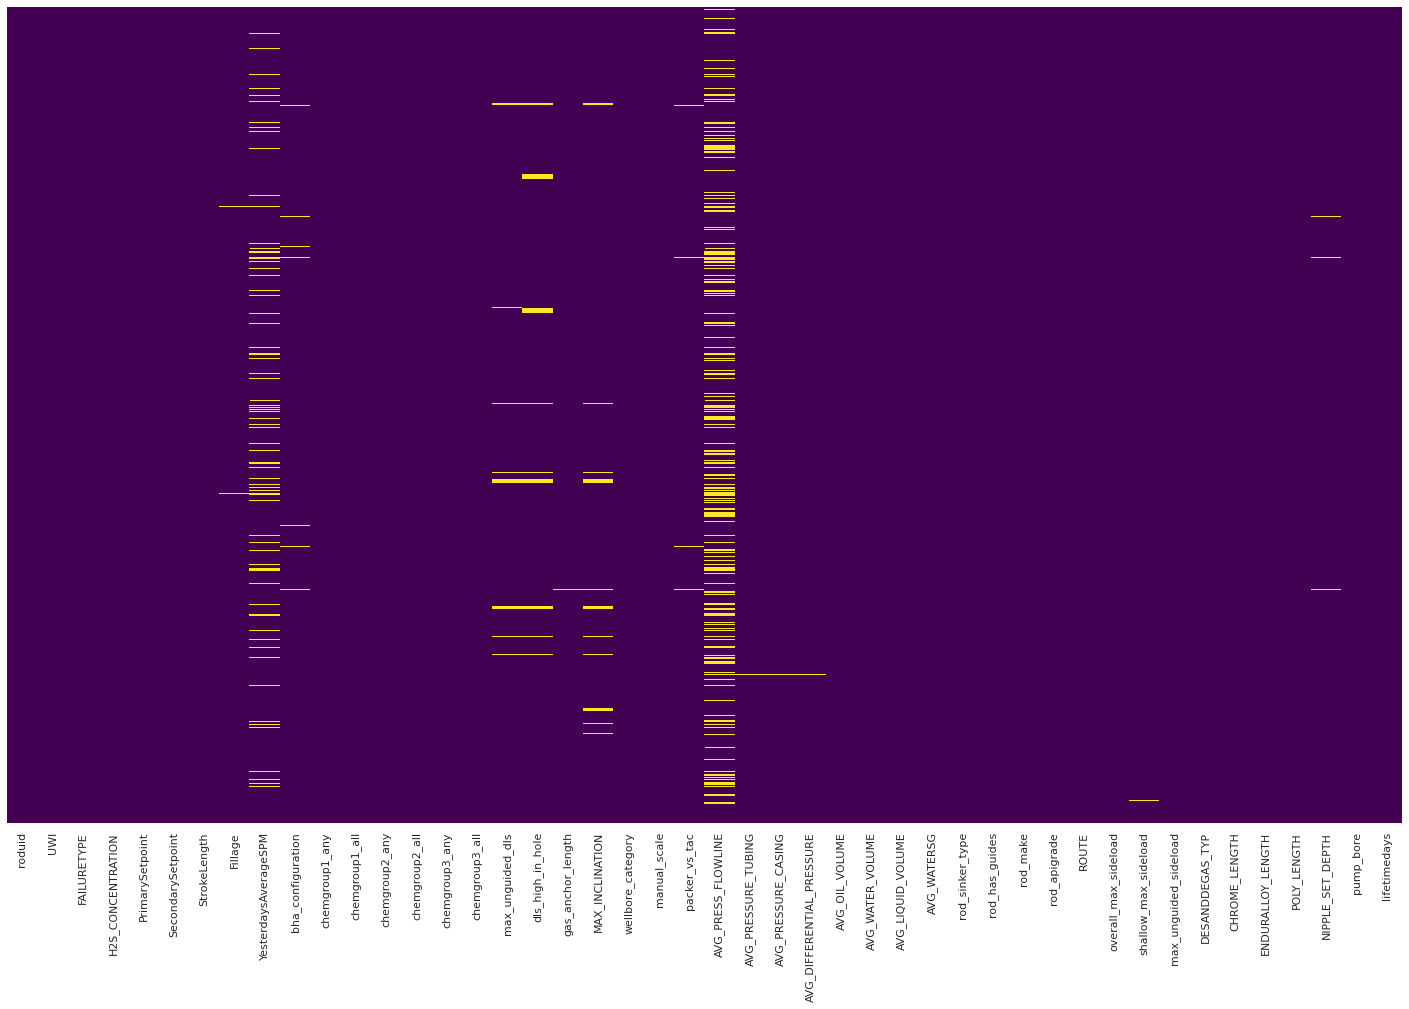

In [16]:
sns.heatmap(test_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Consider `AVG_PRESS_FLOWLINE`:

In [17]:
getPercentNull(test_data,'AVG_PRESS_FLOWLINE')

0.2250879249706917

In [18]:
getPercentNull(raw_data,'AVG_PRESS_FLOWLINE')

0.2250879249706917

The null values from `AVG_PRESS_FLOWLINE` do not appear to overlap with the null values from `GrossStrokeLength`, so we will also drop this column.

In [19]:
del test_data['AVG_PRESS_FLOWLINE']
raw_data = test_data

`YesterdaysAverageSPM` still has a large number of null values.

In [20]:
getPercentNull(raw_data,'YesterdaysAverageSPM')

0.09495896834701055

<AxesSubplot:>

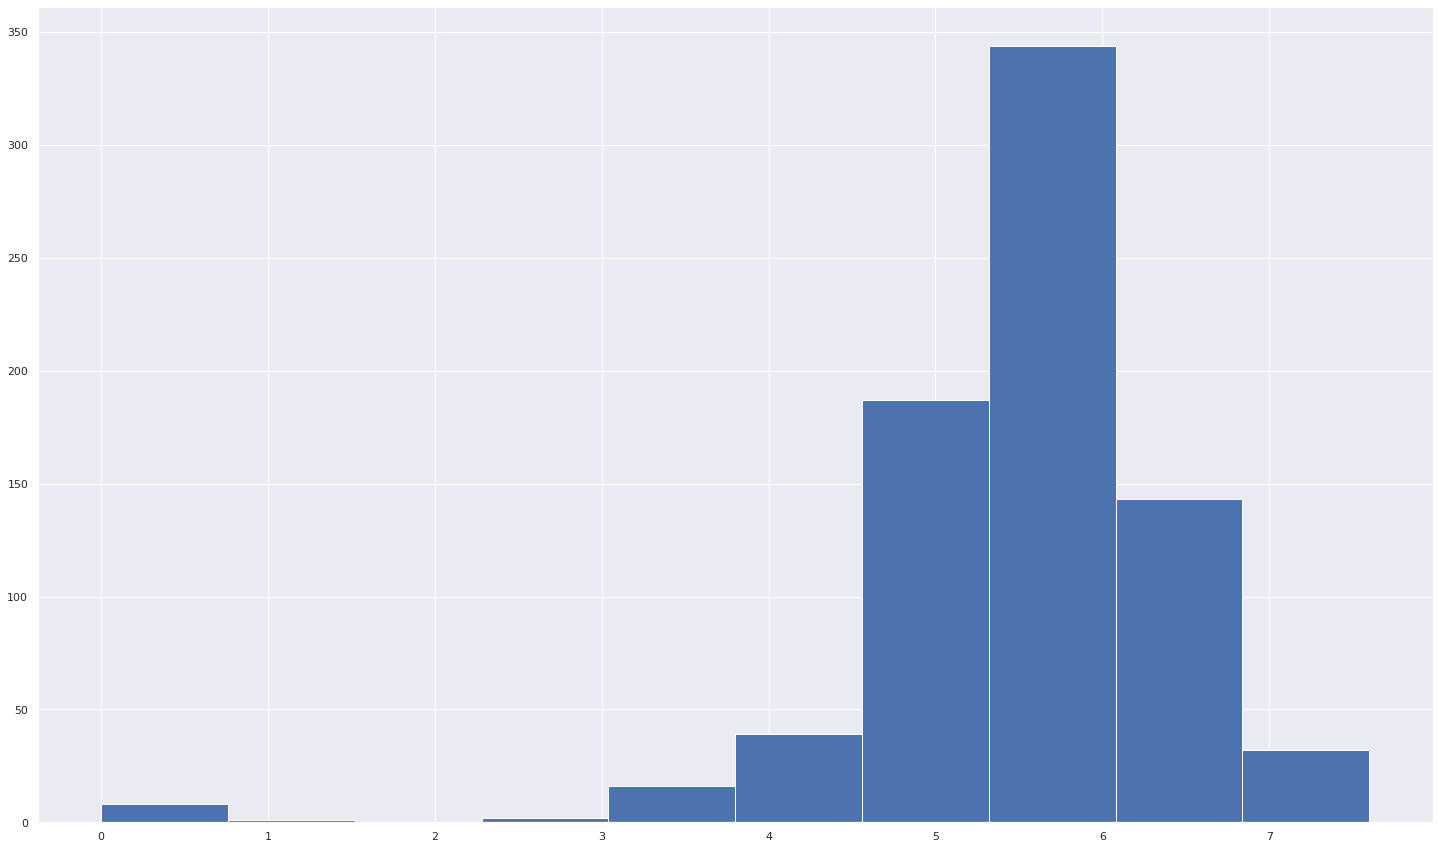

In [21]:
#mask = ( raw_data['FAILURETYPE'] == "Tubing" )
#mask = ( raw_data['FAILURETYPE'] == "Sucker Rod Pump" )
#mask = ( raw_data['FAILURETYPE'] == "Rods" )
#raw_data['YesterdaysAverageSPM'][mask].hist()
raw_data['YesterdaysAverageSPM'].hist()

Because of the nature of `YesterdaysAverageSPM`, it is a good candidate for imputation.

In [22]:
def impute_by_failuretype_medians(df, columnName):
    for failure_type in df['FAILURETYPE'].value_counts().index.tolist():
        notnull_mask = (df['FAILURETYPE'] == failure_type) & (df[columnName].notnull())
        imputed_value = (df[columnName][notnull_mask].median()).round(3)
        print("Imputed value for " + failure_type + ": " + str(imputed_value))
        df[columnName] = df[columnName].fillna(imputed_value)
    return df

In [23]:
raw_data = impute_by_failuretype_medians(raw_data, 'YesterdaysAverageSPM')

Imputed value for Tubing: 5.7
Imputed value for Sucker Rod Pump: 5.7
Imputed value for Rods: 5.8


Consider `max_unguided_dls`, another candidate for imputation:

In [24]:
getPercentNull(raw_data,'max_unguided_dls')

0.016412661195779603

<AxesSubplot:>

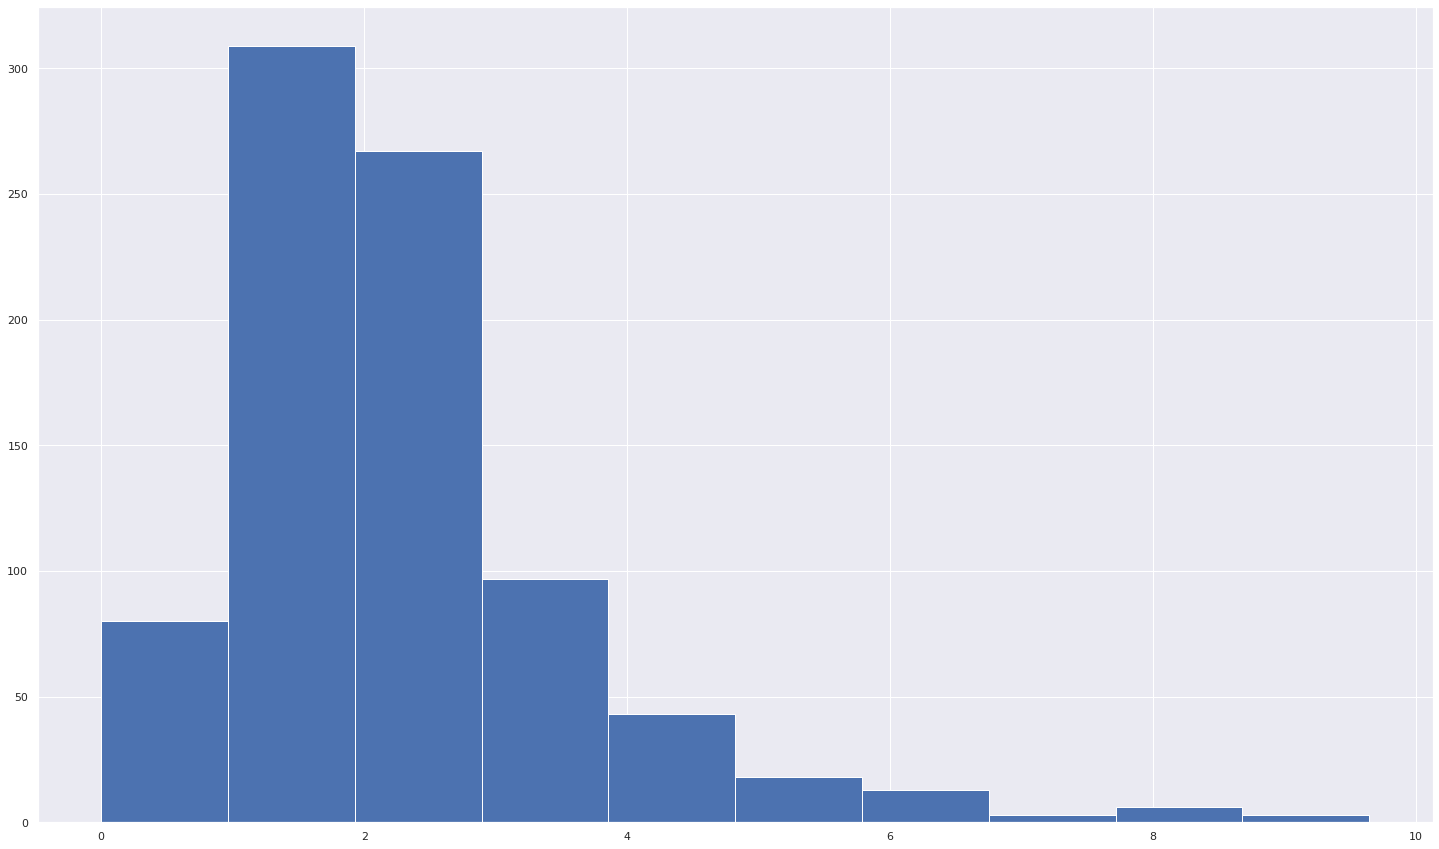

In [25]:
raw_data['max_unguided_dls'].hist()
#raw_data['max_unguided_dls'].hist(by=raw_data['FAILURETYPE'])

For this column, we will impute based on means by failure type since the data has a greater spread.

In [26]:
def impute_by_failuretype_means(df, columnName):
    for failure_type in df['FAILURETYPE'].value_counts().index.tolist():
        notnull_mask = (df['FAILURETYPE'] == failure_type) & (df[columnName].notnull())
        imputed_value = (df[columnName][notnull_mask].mean()).round(3)
        print("Imputed value for " + failure_type + ": " + str(imputed_value))
        df[columnName] = df[columnName].fillna(imputed_value)
    return df

In [27]:
raw_data = impute_by_failuretype_means(raw_data, 'max_unguided_dls')

Imputed value for Tubing: 2.352
Imputed value for Sucker Rod Pump: 2.08
Imputed value for Rods: 2.291


Consider `dls_high_in_hole` as another another candidate for imputation.

In [28]:
getPercentNull(raw_data,'dls_high_in_hole')

0.026963657678780773

In [29]:
raw_data[['dls_high_in_hole', 'max_unguided_dls']].corr()

,dls_high_in_hole,max_unguided_dls
dls_high_in_hole,1.000000,0.727752
max_unguided_dls,0.727752,1.000000


Drop `dls_high_in_hole` as redundant.

In [30]:
del raw_data['dls_high_in_hole']

Impute `MAX_INCLINATION`

In [31]:
raw_data = impute_by_failuretype_means(raw_data, 'MAX_INCLINATION')

Imputed value for Tubing: 4.75
Imputed value for Sucker Rod Pump: 4.471
Imputed value for Rods: 5.54


Check progress using heatmap

<AxesSubplot:>

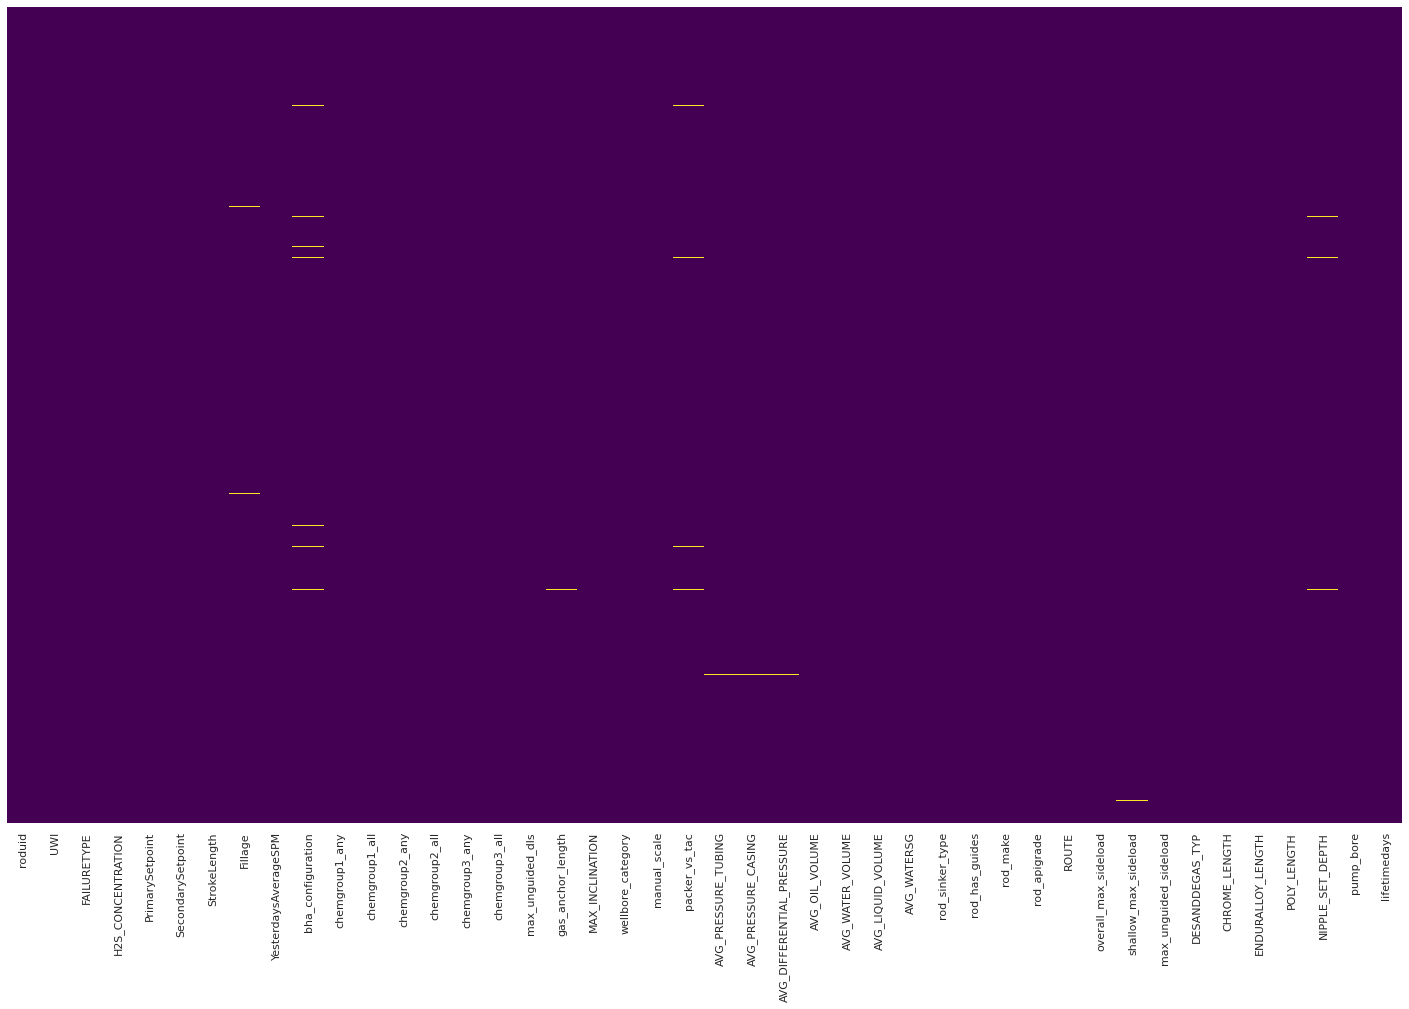

In [32]:
sns.heatmap(raw_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [33]:
raw_data = impute_by_failuretype_means(raw_data, 'Fillage')

Imputed value for Tubing: 83.762
Imputed value for Sucker Rod Pump: 79.537
Imputed value for Rods: 83.101


In [34]:
raw_data = impute_by_failuretype_means(raw_data, 'gas_anchor_length')

Imputed value for Tubing: 16.279
Imputed value for Sucker Rod Pump: 16.751
Imputed value for Rods: 16.236


Drop `packer_vs_tac` because the majority of values are either null or other

In [35]:
raw_data['packer_vs_tac'].value_counts()

OTHER_ANCHOR    648
arrowset        142
OTHER_PACKER     37
slimline         13
hornet            9
Name: packer_vs_tac, dtype: int64

In [36]:
del raw_data['packer_vs_tac']

Impute `shallow_max_sideload`

In [37]:
raw_data = impute_by_failuretype_means(raw_data, 'shallow_max_sideload')

Imputed value for Tubing: 210.12
Imputed value for Sucker Rod Pump: 176.44
Imputed value for Rods: 209.994


Impute `NIPPLE_SET_DEPTH`

In [38]:
raw_data = impute_by_failuretype_means(raw_data, 'NIPPLE_SET_DEPTH')

Imputed value for Tubing: 9874.534
Imputed value for Sucker Rod Pump: 9848.08
Imputed value for Rods: 10033.064


Consider `bha_configuration`:

In [39]:
getPercentNull(raw_data, 'bha_configuration')

0.008206330597889801

In [40]:
raw_data = raw_data[raw_data['bha_configuration'].notnull()]

Remove row where all pressure values are null:

In [41]:
mask = ~( raw_data['AVG_PRESSURE_TUBING'].isnull() & raw_data['AVG_PRESSURE_CASING'].isnull() & raw_data['AVG_DIFFERENTIAL_PRESSURE'].isnull())
raw_data = raw_data[mask]

Check progress using heatmap:

<AxesSubplot:>

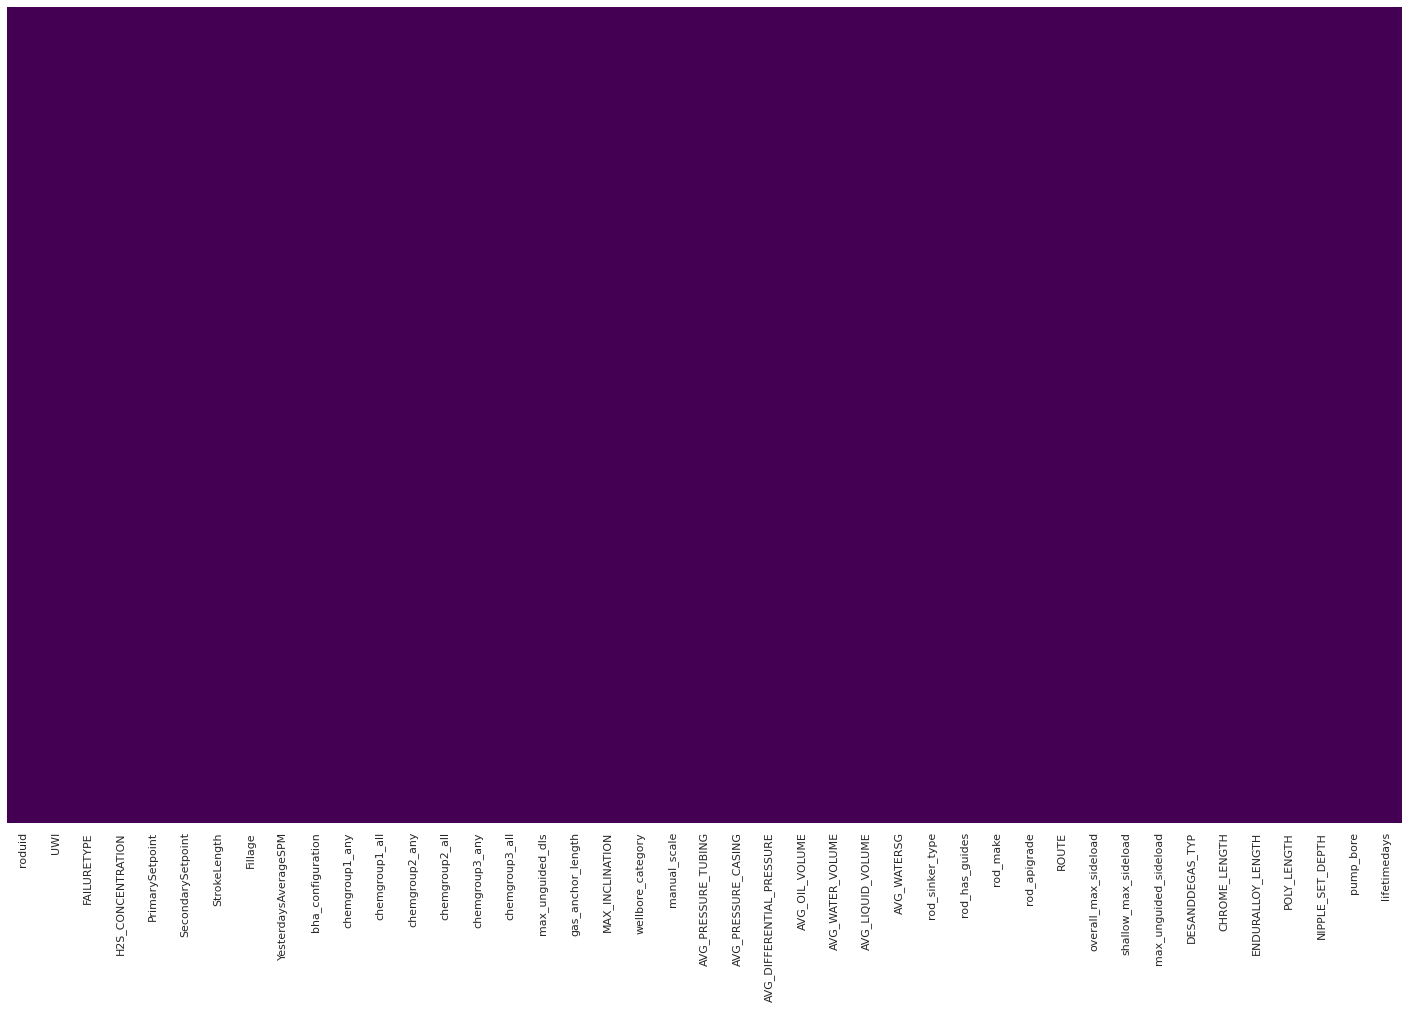

In [42]:
sns.heatmap(raw_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [43]:
raw_data.isnull().sum().sum()

0

Look at that beautiful purple square!  Looks like we're done for now.

### Exporting Data to a CSV
This cell exports the cleaned data frame to the file `rodpump_cleaned.csv` in the project home directory.  
Use wisely, and with caution! Do not uncomment until you are ready to export!

In [44]:
raw_data.to_csv('../rodpump_cleaned.csv',index=False,header=True)